# Image Analysis: Using bag of visual words for scene classification.

## Training phase

### First Part: Introduction

Before extracting features we need to get our hands into a dataset and import the necessary packages. I also used the **OpenCV Python Package (3.4.1)** in the implementation of this project, to download any version, go to [the official OpenCV website](https://opencv.org/releases.html); other essential packages for Computer Vision, Machine Learning and utilities packages were used such as `numpy`, `os`, `matplotlib` and others.

In [4]:
# Import modules
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
import confmat as cfmat
import cv2 as cv
import numpy as np
import os
from imutils import paths
import pickle
%matplotlib inline

### Part 2. Getting the data

For the purpose of brevity, simplicity and computational "cheapness" I am going to use 3 categories, however, this algorithm can easily be expanded or scaled into any number of categories, although more efficient approaches may be needed for fast computation of the classification task. Caltech 101 with 101 categories is an example dataset of a lot of categories and images.

In [5]:
dataset_path = '../data/upf/training_set/'
categories = os.listdir(dataset_path)
print("Training path: ", dataset_path)
print("Training categories: ", categories)

Training path:  ../data/upf/training_set/
Training categories:  ['aeroplane', 'bicycle', 'car']


In [6]:
# Get all the path to the images and save them in a list
# image_paths and the corresponding label in image_paths
# The path is defined in the `train_path` variable.
# Also, the label is just a number in this case.
image_paths = []
image_classes = []
class_id = 0
for category in categories:
    dir = os.path.join(dataset_path, category)
    class_path = list(paths.list_images(dir)) # This is the path to all the images given A SINGLE CLASS
    # Stores the path to all the images in the images_paths variable which has all of the training images.
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path) # Assigns a label to each image path
    class_id+=1
print(image_classes)
print(len(image_classes))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
51


### Part 3. Keypoints and Descriptors of all of the images

Thanks to the OpenCV library we can detect the SIFT keypoints and compute its correspondent descriptors, which can then be stored in a high-dimensional matrix for further computation

#### SIFT Note: 

Even though SIFT has different parameters, the paper by Lowe gives some empirical data which can be summarized as, number of octaves = 4, number of scale levels = 5, initial $\sigma = 1.6$, $k = \sqrt{2}$ etc as optimal values.

In [7]:
# Detect SIFT Keypoints
sift        = cv.xfeatures2d.SIFT_create()
# List where all the descriptors will be stored
des_list = []
print("Calculating all the descriptors and keypoints...")
for image_path in image_paths:
    print("Calculating for image ["+ image_path +"]           ", end="\r")
    im  = cv.imread(image_path)
    gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY) # Converts from one color space to another (grayscale)
    kp, des = sift.detectAndCompute(gray,None)
    des_list.append((image_path, kp, des))
print("\nDone!")

Calculating all the descriptors and keypoints...
Calculating for image [../data/upf/training_set/car\9.jpg]                  
Done!


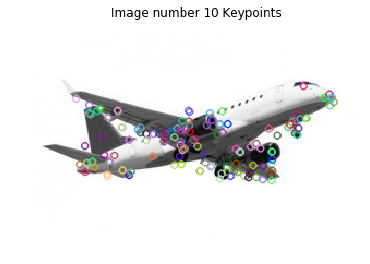

In [8]:
# Example for the 3rd image
IMAGE_N = 10
im = cv.imread(des_list[IMAGE_N][0])
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
kp, des = sift.detectAndCompute(gray, None)
kpImg = cv.drawKeypoints(gray, kp, im)
plt.imshow(im, cmap='gray')
plt.axis("off")
plt.title("Image number "+str(IMAGE_N)+" Keypoints")
plt.show()

In [9]:
# Stack all the descriptors vertically in a numpy array
print("Stacking all the descriptors in a numpy array...")
descriptors = des_list[0][2]
for image_path, keypoints, descriptor in des_list[1:]:
    print("Calculating for image ["+ image_path +"]           ", end="\r")
    descriptors = np.vstack((descriptors, descriptor))
print("\nDone!")

Stacking all the descriptors in a numpy array...
Calculating for image [../data/upf/training_set/car\9.jpg]                  
Done!


#### Optional. Save the descriptors variable in an external file.

In [10]:
pickle.dump(descriptors, open('descriptors.sav', 'wb'))

### Part 4. Apply K-means

Once we have all the descriptors, we must build a vocabulary, unlike words written in human languages, we do not have a strictly defined visual vocabulary, so that's why we use the unsupervised learning algorithm K-means to build it according to the collected SIFT descriptors of our images. This task can be computationally expensive, specially for a lot of categories and when executing the K-means algorithm more than once (in order to average results).

In [11]:
# Perform k-means clustering
k = 500
voc, variance = kmeans(descriptors, k, 1)
print("Done doing K-means")

Done doing K-means


Here is where we compute the distance for each pseudo-word (SIFT descriptor) inside a document (image), to each of the means of the clusters (words); each SIFT descriptor has a cluster as a word, but we do not know which one, that is why we just assign to it the one that has the minimum distance.

In [19]:
# Create the histogram itself of the image features
im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    print("Calculating distance for image "+str(i)+"...", end="\r")
    words, distance = vq(des_list[i][2],voc)
    for w in words:
        im_features[i][w] += 1

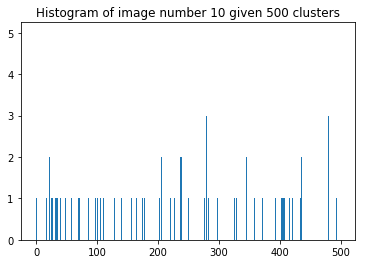

In [13]:
plt.bar(range(k), im_features[IMAGE_N])
plt.title("Histogram of image number "+ str(IMAGE_N) +" given "+ str(k) + " clusters")
plt.show()

Also, a weighting schema can be useful to give more emphasis to the words that are more **discriminant**.

The number of times a term occurs in a document is called its **term frequency**. Is a way of weighting documents given a list of the words that form the document. That is, if a word appears a lot in a document, it may be important. Further weighting schemas can be done as well, such as the _inverse document frequency_. Given the term $t$ and its frequency in a document $i$, its **term frequency $tf_i$** is:

$$tf_i = t \cdot f_i$$

One can define the **document frequency** or $df_i$ as the number of occurences that any given term appears in a group of documents, hence the name. The **inverse document frequency** is a weighting scheme that takes into account the document frequency to apply weights to each word. Because, if a certain word appears in all of the documents, is not a discriminative word. The $idf_i$ weighting schema has the following equation:

$$idf_i = \log{\frac{N}{df_i}}$$

Where $N$ is the total number of documents, and thus, if the document frequency is low, it's a rare word which has a high weight.

We then can use the TF-IDF weighting for our features.

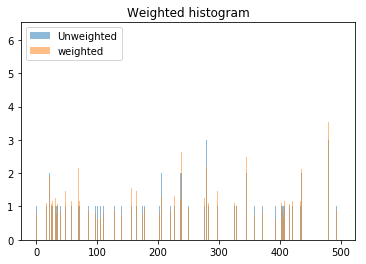

In [14]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths) + 1) / (1.0*nbr_occurences + 1)), 'float32')
scaled_im_features = im_features * idf
plt.bar(range(k), im_features[IMAGE_N], alpha=0.5)
plt.bar(range(k), scaled_im_features[IMAGE_N], alpha=0.5)
plt.title("Weighted histogram")
plt.legend(['Unweighted', 'weighted'])
plt.show()

#### Feature normalization or scaling
The standard scaler allows us to normalize our already tf-idf weighted feature vector for each document (image). The normalization is defined as follows $Normalize(X) = \frac{X - \mu}{\sigma}$, where $\mu, \sigma$ represent the mean and the standard deviation respectively.

In [20]:
# Scaling the words
stdSlr = StandardScaler().fit(scaled_im_features)
scaled_im_features = stdSlr.transform(scaled_im_features)

### Part 5. Train a Classifier

**NOTE**: The following classifier is still in testing. I still would like to work on this classifier, that's why bagging with a random forest classifier is not used in this classification task.

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = DecisionTreeClassifier(max_depth=None, random_state=0)
baggingclf = BaggingClassifier(RandomForestClassifier())
cv = cross_validate(baggingclf, X=scaled_im_features, y=image_classes, return_train_score=True, cv=10)
print("Training Score: ", cv['train_score'].mean())
print("Mean cross-validation score: ", cv['test_score'].mean())
clf.fit(X=scaled_im_features, y=image_classes)

Training Score:  0.9913888888888888
Mean cross-validation score:  0.8166666666666667


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

Let's use a relatively simple model, a linear support vector machine. According to the `sklearn` documentation, the penalty function is the $L_2$ norm.

In [17]:
clf = LinearSVC()
cv = cross_validate(clf, X=scaled_im_features, y=image_classes, return_train_score=True, cv=5)
print("Training Score: ", cv['train_score'].mean())
print("Mean cross-validation score: ", cv['test_score'].mean())
clf.fit(X=scaled_im_features, y=image_classes)

Training Score:  1.0
Mean cross-validation score:  0.8222222222222222


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [18]:
# Save the SVM
joblib.dump((clf, categories, stdSlr, k, voc, idf), "svm.pkl", compress=3)

['svm.pkl']